# <p style="text-align: center;">EE 379K: Data Science Lab</p>
# <p style="text-align: center;">Lab 6 - 10/16/17</p>
## <p style="text-align: center;">Rachel Chen and Kevin Yee</p>
### <p style="text-align: center;"> rjc2737 and kjy252</p>

#Problem 1 
In this problem we will use synthetic data sets to explore the bias-variance tradeoffincurred by using regularization.

* Generate data of the form: 
$$ y = X\beta + \epsilon $$ 

where X is an n x p matrix where n = 51, p = 50, and each $X_{ij} \sim N(0,1)$. Also, generate the noise according to $\epsilon_i \sim N(0,1/4)$. Let $\beta$ be the all ones vector for simplicity.

By repeatedly doing the experiment and generating fresh data (fresh X, and y, and hence $\epsilon$ but keeping $\beta$ fixed, you will estimate many diffferent solutions, $\hat{\beta}$. Estimate the mean and variance of $\hat{\beta}$. Note that $\hat{\beta}$ is a vector, so for this exercise simply estimate the variance of a single component.


* Use ridge regression i.e. $l_2$ regularization. Vary the regularization coefficient $\lambda = 0.01, 0.1, 1, 10, 100$ and repeat the above experiment. What do you observe? As you increase $\lambda$ is the model becoming more simple or more complex? As you increase $\lambda$ is performance becoming better or worse? 

#Answer

In [12]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import cross_val_score
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [15]:
#generate data
X = np.random.normal(0,1, size = (51,50))
e = np.random.normal(0,.25)
beta = np.ones((51,50))

#Create OLS unbiased model to estiamte beta hat 
linear = LinearRegression()

#Compute y
y = X.dot(beta.T) + e

#Compute coefficient with Linear regression model: 
linear.fit(X,y)

mean = []
var = []
for i in range(1,1000):
    X = np.random.normal(0,1, size = (51,50))
    e = np.random.normal(0,.25)
    y = X.dot(beta.T) + e
    linear.fit(X,y)
    mean.append(np.mean(linear.coef_))
    var.append(np.var(linear.coef_))
    
print "Ordinary Least Squares:"
print " Mean of beta hat using OLS: " + str(np.mean(mean))
print " Variance of beta hat using OLS: " + str(np.mean(var))

alphas = [0.01, 0.1, 1, 10, 100]
print "\nRidge Regression:"
for alpha in alphas:
    ridge = Ridge(alpha = alpha).fit(X,y)
    print
    print "lambda = " + str(alpha)
    print " Mean of beta hat using Ridge: " + str(np.mean(ridge.coef_))
    print " Variance of beta hat using Ridge: "+ str(np.var(ridge.coef_))

Ordinary Least Squares:
 Mean of beta hat using OLS: 1.0
 Variance of beta hat using OLS: 1.42720044573e-26

Ridge Regression:

lambda = 0.01
 Mean of beta hat using Ridge: 0.997770897172
 Variance of beta hat using Ridge: 0.000556458698986

lambda = 0.1
 Mean of beta hat using Ridge: 0.985989435946
 Variance of beta hat using Ridge: 0.00248364742776

lambda = 1
 Mean of beta hat using Ridge: 0.914111546449
 Variance of beta hat using Ridge: 0.0152418583151

lambda = 10
 Mean of beta hat using Ridge: 0.649948478047
 Variance of beta hat using Ridge: 0.0644611609588

lambda = 100
 Mean of beta hat using Ridge: 0.251750393288
 Variance of beta hat using Ridge: 0.0365404969792


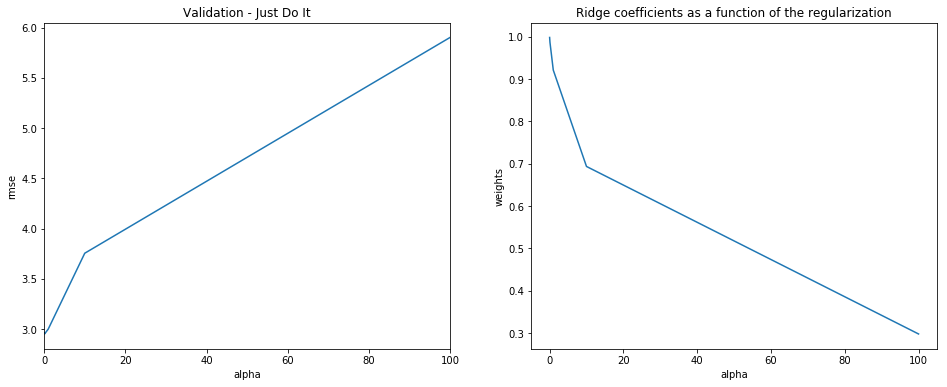

In [58]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)


alphas = [0.01, 0.1, 1, 10, 100]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

coefs = [Ridge(alpha = alpha).fit(X,y).coef_.mean() for alpha in alphas]

plt.figure(figsize=(16,6))
plt.subplot(121)
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

plt.subplot(122)
plt.plot(alphas,coefs)
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')


From the figure comparing alpha and rmse, the model is getting increasingly worse as alpha is increasing

From the figure comparing alpha and weights, the model is getting increasingly simpler as the weights of $\hat{\beta}$ decreases


# Problem 2 
Problem 9 from Chapter 6.
(Predicting  the  number  of  applications  in  College)  Note  that  you  will  have  to  read  about  PCR(Principal Components Regression) and PLS (Partial Least Squares ) in the book, since we did not discuss these in class.

![](http://i.markdownnotes.com/image_7m46Jzg.png)

#Answer

In [48]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale 
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.model_selection import cross_val_score
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.cross_validation import train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn import cross_validation
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [49]:
college = pd.read_csv("Data/College.csv")

#split data up
y = college.Apps
X = college.drop('Apps',axis = 1)
X['Private'] = X['Private'].replace('Yes',1).replace('No',0)
X = X.loc[:, "Private":]
X.head()

#split data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state=20)


#iniatlize models 
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
ols = LinearRegression()
ridgeCV = RidgeCV(alphas=alphas, cv=10)
lassoCV = LassoCV(alphas=alphas, cv=10, max_iter=10000)

# Least Squares
ols.fit(X_train, y_train)
olsmse = mean_squared_error(y_test, ols.predict(X_test))

print "OLS Linear Regression MSE: " + str(olsmse)

# RidgeCV 
ridgeCV.fit(X_train, y_train)
ridgemse = mean_squared_error(y_test, ridgeCV.predict(X_test))
                  
print "Ridge Regression MSE: " + str(ridgemse)
# LassoCV
lassoCV.fit(X_train, y_train)
lassomse = mean_squared_error(y_test, lassoCV.predict(X_test))
                  
print "Lasso Regression MSE: " + str(lassomse)
print "Lasso, Non Zero Coefficients", len(lassoCV.coef_.nonzero()[0])

OLS Linear Regression MSE: 788016.339525
Ridge Regression MSE: 788849.335783
Lasso Regression MSE: 789339.4189
Lasso, Non Zero Coefficients 17


[  31.54   57.04   64.04   69.86   75.44   80.48   84.15   87.57   90.6
   93.03   95.05   96.85   97.95   98.74   99.37   99.84  100.01]


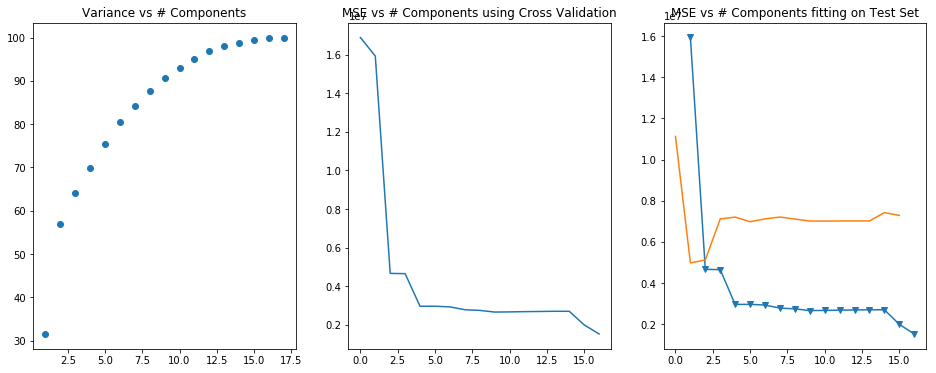

In [50]:
# https://stats.stackexchange.com/questions/82050/principal-component-analysis-and-regression-in-python
#PCR
pca = PCA()
pc_train_x = pca.fit_transform(scale(X_train))
pc_test_x = pca.fit_transform(scale(X_test))


fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,6))

#Plot Expalained Variance to determine best components
pc_train_x = pca.fit_transform(scale(X_train))
ax1.set_title("Variance vs # Components")
xVals = [n for n in range(1,len(X_train.columns)+1)]
explainedVar = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
print explainedVar
ax1.scatter(xVals,explainedVar)



mse = []
linear = LinearRegression()


#Find number of components using cross validation mse scores
#Zero Components
mse.append(np.mean(-1 * cross_val_score(linear, np.ones((len(pc_train_x), 1)),
                                        y_train, cv=20, scoring='neg_mean_squared_error')))

#One to Ten Components
for i in range(1, len(X_train.columns)):
    mse.append(np.mean(-cross_val_score(linear, pc_train_x[:, :i], y_train, cv=10,
                                    scoring='neg_mean_squared_error')))
    
#Plot MSE to determine best components
ax2.plot(mse)
ax2.set_title("MSE vs # Components using Cross Validation")

#Plot disregarding intercept
ax3.plot([n for n in range(1,len(X_train.columns))],mse[1:],'-v')

pcamse = []
for i in range(1,len(X_train.columns)):
    linear.fit(pc_train_x[:, :i], y_train)
    pcamse.append(mean_squared_error(y_test, linear.predict(pc_test_x[:,:i])))
    
ax3.plot(pcamse)
ax3.set_title("MSE vs # Components fitting on Test Set")

In [51]:
print "The minimum MSE obtained is with 17 components with an MSE of: " + str(min(mse))
print "The MSE obtained with 10 components is: "+str(mse[9])+" which explains about: "+str(explainedVar[9])+" percent of variance"

The minimum MSE obtained is with 17 components with an MSE of: 1527014.99208
The MSE obtained with 10 components is: 2663349.37745 which explains about: 93.03 percent of variance


Using cross-validation of the training set with a PCR model, we recognize that 17 components produces the lowerst of MSE of ~1500000. 

However, this makes the purpose of PCR pointless. We recognize that 10 components, achieves 93% of variance (about 1/2 of the features can explain the variance of the data set).
Using M = 10, we get a MSE of ~2660000.

When running the model on the test set, we saw that 3 components perfromed the best (orange line in figure 3).


The lowest MSE obtained is: 1399101.47503 with 9 components


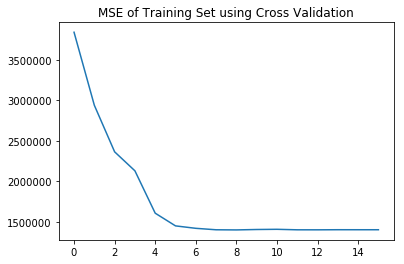

In [59]:
# Using PLS 
# http://www.mathstat.dal.ca/~aarms2014/StatLearn/assignments/A3sol_2.pdf
# https://rpubs.com/ppaquay/65562
mse = []
mse.append(0);
for i in range(1, len(X_train.columns)):    
    plsReg = PLSRegression(n_components=i)
    mse.append(np.mean(-cross_val_score(plsReg, scale(X_train), y_train, cv=10,
                                    scoring='neg_mean_squared_error')))

    #print "Number of Components: ", i, "MSE Score: ", mse[i]


plt.plot(mse[1:])
plt.title("MSE of Training Set using Cross Validation")

print "\nThe lowest MSE obtained is:",str(min(mse[1:])), "with",str(mse.index(min(mse[1:]))), "components"

Using, PLS, we observe that the minmimum component obtained is with M = 9 components with an MSE of ~1400000.

# Problem 3

![](http://i.markdownnotes.com/image_9kryzAh.png)


# Problem 4

**Ordinary Least Squares:**

$$min_\beta: ||X\beta -y||_2^2 = \sum(X_i\beta-y_i)^2$$
1. Vector Notation. Derive and Set to Zero.
$$2X^T(X\beta-y) = 0 $$ 


2. $$2X^TX\beta-2X^Ty =0$$
$$~$$
$$2X^TX\beta - 2X^Ty = 0 $$
$$~$$
$$ X^T X \beta = X^T y $$
$$~$$
$$ \hat{\beta} = (X^TX)^-1X^Ty$$


**Ridge Regression:**
$$min_\beta: ||X\beta -y||_2^2 + \lambda ||\beta||^2_2= \sum(X_i\beta-y_i)^2 + \lambda \sum \beta_i^2$$

1. Make Vector Notation, Derive and set to zero

$$2X^T(X\beta-y) + 2\lambda \beta = 0 $$ 

 
2. $$2X^TX\beta-2X^Ty + 2\lambda\beta =0$$
$$~$$
$$ X^T X \beta + \lambda\beta = X^T y $$
$$~$$
$$(X^TX + \lambda I)\beta = X^Ty$$
$$~$$
$$\hat{\beta} = (X^TX + \lambda I)^{-1}X^Ty$$